# Readers

In [ ]:
#| default_exp readers

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export 

from copy import deepcopy
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import pylab as plt
from dataclasses import dataclass
from scipy.stats import linregress

import json
import gzip
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable
import os
from circadian.utils import *
import random
import difflib
import glob 
import os
from scipy.ndimage import gaussian_filter1d
from os import read
pd.options.mode.chained_assignment = None

import glob
import os
import random
import difflib
from scipy.ndimage import gaussian_filter1d

from  jsonschema import validate
from fastcore.basics import *
from circadian.plots import Actogram
import circadian
from pathlib import Path


In [ ]:
#| export 

# path to the data folder
EXAMPLE_DATA = circadian.__path__[0]

In [ ]:
#| exports

wearable_schema = {
    type: "object",
    "properties": {
            "steps": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "start": { "type": "number" },
                    "end": { "type": "number" },
                    "steps": { "type": "number" } } },
                "minItems": 1
            },
            "wake": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "start": { "type": "number" },
                    "end": { "type": "number" },
                    "wake": { "type": "number" } } }
            },
            "heartrate": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "timestamp": { "type": "number" },
                    "heartrate": { "type": "number" },
            } } },
    },
    "required": ["steps", "wake", "heartrate"]
}
    

In [ ]:
test_wearable_data = {
    "steps": [ { "start": 0, "end": 1, "steps": 10 } ], 
    "heartrate": [ { "timestamp": 0, "heartrate": 10 } ],
    "wake": [ { "start": 0, "end": 1, "wake": 1.0} ]
}

validate(instance=test_wearable_data, schema=wearable_schema)


Define the WearableData class 

In [ ]:
#| export


@dataclass
class WearableData:
    
    _dataframe: pd.DataFrame # the dataframe that holds the data must have datetime columns plus any other wearable streams from steps, heartrate, wake, light_estimate, activity
    phase_measure: np.ndarray = None
    phase_measure_times: np.ndarray = None
    subject_id: str = "unknown-subject"
    data_id: str = "unknown-data-id"
    meta_data: Dict[str, Any] = None
    
    @property
    def datetime(self) -> np.ndarray:
        return self._dataframe["datetime"].values
    
    @property
    def timestamp(self) -> np.ndarray:
        return self._dataframe["timestamp"].values
    
    @property
    def time_total(self) -> np.ndarray:
        return self._dataframe["time_total"].values
    
    @property
    def light_estimate(self) -> np.ndarray:
        if 'light_estimate' in self._dataframe.columns:
            return self._dataframe["light_estimate"].values
        if 'steps' in self._dataframe.columns:
            return self._dataframe["steps"].values
        if 'activity' in self._dataframe.columns:
            return self._dataframe["activity"].values
        return np.ones_like(self.time_total)*np.nan
    
    @property
    def steps(self) -> np.ndarray:
        if 'steps' in self._dataframe.columns:
            return self._dataframe["steps"].values
        else:
            return np.ones_like(self.time_total)*np.nan
    
    @property
    def activity(self) -> np.ndarray:
        if 'activity' in self._dataframe.columns:
            return self._dataframe["activity"].values
        else:
            return np.ones_like(self.time_total)*np.nan
    
    @property
    def heartrate(self) -> np.ndarray:
        if 'heartrate' in self._dataframe.columns:
            return self._dataframe["heartrate"].values
        else:
            return np.ones_like(self.time_total)*np.nan # generate a nan array
    
    @property
    def wake(self) -> np.ndarray:
        if 'wake' in self._dataframe.columns:
            return self._dataframe["wake"].values
        else:
            return np.ones_like(self.time_total)*np.nan # generate a nan array
        
    @property
    def time_hour_bounds(self) -> Tuple[float, float]:
        return (self.time_total[0], self.time_total[-1])
    
    @property
    def date_bounds(self):
        start_date = pd.to_datetime(self.datetime[0], unit='s')
        end_date = pd.to_datetime(self.datetime[-1], unit='s')
        return (start_date, end_date)
    
    @staticmethod
    def utc_to_hrs(d: datetime):
        return d.hour+d.minute/60.0+d.second/3600.0

    def __post_init__(self):
        # Check that we have the required columns
        assert "datetime" in self._dataframe.columns
        assert "time_total" in self._dataframe.columns
        
    def _copy_with_metadata(self, df: pd.DataFrame) -> "WearableData":
        return WearableData(df, 
                            self.phase_measure, 
                            self.phase_measure_times, 
                            self.subject_id, 
                            self.data_id, 
                            meta_data=self.meta_data)

    def build_sleep_chunks(self, chunk_jump_hrs: float = 12.0) -> List[np.ndarray]:
        time_total = self.time_total
        steps = self.steps
        heartrate = self.heartrate
        wake = self.wake
        data = np.stack((steps, heartrate, wake), axis=0)
        j_idx = np.where(np.diff(time_total) > chunk_jump_hrs)[0]
        return np.split(data, j_idx, axis=1)

    def get_date(self, time_hr: float):
        idx = np.argmin(np.abs(np.array(self.time_total) - time_hr))
        return pd.to_datetime(self.datetime[idx], unit='s')

    def get_timestamp(self, time_hr: float):
        idx = np.argmin(np.abs(np.array(np.hstack(self.time_total)) - time_hr))
        return np.hstack(self.datetime)[idx]

    def trim_by_idx(self, 
                    idx1: int, # First index to keep
                    idx2: int = None # second idx should be greater than idx1, defaults to the last value
                    ) -> 'WearableData':
        df = self._dataframe.loc[idx1:idx2, :]
        return self._copy_with_metadata(df)

    def trim_by_hour(self, 
                     hour_start: float, # First hour to keep
                     hour_end: float, # second hour should be greater than hour_start
                     inplace: bool = False, # if true, the dataframe is modified in place, otherwise a copy is returned
                     ) -> 'WearableData':
        # Trim the __dateframe to be within the interval [t1,t2]
        df = self._dataframe.loc[(self._dataframe.time_total > hour_start) & (self._dataframe.time_total < hour_end)]
        if inplace:
            self._dataframe = df
            return 
        return self._copy_with_metadata(df)
    
    def trim_by_timestamp(self, timestamp_start: float, timestamp_end: float) -> 'WearableData':
        # Trim the __dateframe to be within the interval [t1,t2]
        df = self._dataframe.loc[(self._dataframe.datetime > timestamp_start) & (self._dataframe.datetime < timestamp_end)]
        return self._copy_with_metadata(df)
    
    def __getitem__(self, key: str) -> pd.Series:
        return self._dataframe[key]
        
    def head(self, n: int = 5) -> pd.DataFrame:
        return self._dataframe.head(n)
    
    def tail(self, n: int = 5) -> pd.DataFrame:
        return self._dataframe.tail(n) 
    
    def filter(self, filter_fn: Callable[[pd.DataFrame], pd.DataFrame]) -> 'WearableData':
        return self._copy_with_metadata(filter_fn(self._dataframe))
    
    def aggregate(self, agg_fn: Callable[[pd.DataFrame], pd.DataFrame]) -> 'WearableData':
        return self._copy_with_metadata(agg_fn(self._dataframe))
    
    def groupby(self, by: str) -> 'WearableData':
        return self._copy_with_metadata(self._dataframe.groupby(by))
    
    def join(self, other: 'WearableData', how = 'inner') -> 'WearableData':
        return self._copy_with_metadata(self._dataframe.join(other._dataframe, on='datetime', how=how))
    
    def to_json(self, filename: str = None):
        df_trimed = self._dataframe.drop(columns=['datetime'])
        json_dict = {
            'meta_data' : self.meta_data, 
            'phase_measure' : list(self.phase_measure) if self.phase_measure is not None else [],
            'phase_measure_times' : list(self.phase_measure_times) if self.phase_measure_times is not None else [],
            'subject_id' : self.subject_id,
            'data-id' : self.data_id,
            'wearable' : df_trimed.to_dict()
        }
        if filename is None:
            filename = 'wearable_' + self.subject_id + "_" + self.data_id + '.json'
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(json_dict, f, ensure_ascii=False,
                        indent=4, cls = NpEncoder )

    @staticmethod
    def from_json(filename) -> 'WearableData':
        jdict = json.load(open(filename, 'r'))
        df = pd.DataFrame.from_dict(jdict['wearable']) 
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        wdata = WearableData(df)
        for s in jdict.keys():
            if s != 'wearable':
                if isinstance(jdict[s], list):
                    setattr(wdata, s, [np.array(jdict[s])])
                else:
                    setattr(wdata, s, jdict[s])

        return wdata


In [ ]:
#| export

@patch 
def steps_hr_loglinear(self: WearableData
                       ) -> Tuple[float, float]:
        """
        Find the log steps to hr linear regression parameters .
        hr=beta*log(steps+1.0)+alpha
        Returns beta,alpha
        """
        x = np.log(np.hstack(self.steps)+1.0)
        y = np.hstack(self.heartrate)
        x = x[y > 0]
        y = y[y > 0]
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return slope, intercept

Make a routine to plot the available heartrate data.

In [ ]:
#| export

@patch
def plot_heartrate(self: WearableData, 
                   t1=None, 
                   t2=None, 
                   ax: plt.Axes = None,
                   show_plot: bool = True,
                   color: str = 'red', 
                   use_dates: bool = True,
                   *args, 
                   **kwargs
                   ) -> plt.Axes:
        t1 = t1 if t1 is not None else self.time_total[0]
        t2 = t2 if t2 is not None else self.time_total[-1]
        wDataTrimmed = self.trim_by_hour(t1, t2)

        hr = deepcopy(wDataTrimmed.heartrate)
        hr[hr == 0] = np.nan
        if ax is None:
            fig = plt.figure()
            ax = plt.gca()
        
        if use_dates:
            x = pd.to_datetime(wDataTrimmed.datetime, unit='s')
        else:
            x = wDataTrimmed.time_total / 24.0 
        ax.plot(x, hr, color=color, *args, **kwargs)
        ax.set_xlabel('Days')
        ax.set_ylabel('BPM')
        ax.set_title('Heart Rate Data')
        
        if show_plot:
            plt.show()
        return ax
      

In [ ]:
#| export

@patch
def scatter_hr_steps(self: WearableData, 
                     take_log: bool = True, # Log transform the data?
                     *args, 
                     **kwargs):
    
        fig = plt.figure()
        ax = plt.gca()

        steps = np.hstack(self.steps)
        heartrate = np.hstack(self.heartrate)

        if take_log:
            ax.scatter(np.log10(steps[heartrate > 0]+1.0),
                       np.log10(heartrate[heartrate > 0]),
                       color='red',
                       *args,
                       **kwargs)
        else:
            ax.scatter(steps[heartrate > 0], heartrate[heartrate > 0],
                       color='red',
                       *args,
                       **kwargs)

        ax.set_ylabel('BPM')
        ax.set_xlabel('Steps')
        ax.set_title('Heart Rate Data')
        plt.show()

In [ ]:
#| export

@patch
def plot_hr_steps(self: WearableData, 
                  t1: float = None, 
                  t2: float = None, 
                  *args, 
                  **kwargs):

        time_start = t1 if t1 is not None else self.time_total[0]/24.0
        time_end = t2 if t2 is not None else self.time_total[-1]/24.0

        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0.0)
        ax = gs.subplots(sharex=True)
        fig.suptitle(
            f"{self.data_id} Wearable Data: Subject {self.subject_id}")
        hr_all_nan = np.all(np.isnan(self.heartrate))
        if not hr_all_nan:
            ax[0].plot(self.time_total / 24.0, 
                       self.heartrate, 
                       color='red', 
                       *args, 
                       **kwargs)
            
        ax[1].plot(self.time_total / 24.0, 
                   self.steps,
                   color='darkgreen', 
                   *args, 
                   **kwargs)

        sleep_all_nan = np.all(np.isnan(self.wake))
        if not sleep_all_nan:
            ax[1].plot(self.time_total / 24.0, np.array(self.wake) *
                       max(np.median(self.steps), 50.0), color='k')

        if self.phase_measure_times is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]

        ax[1].set_xlabel("Days")
        ax[0].set_ylabel("BPM")
        ax[1].set_ylabel("Steps")
        ax[0].grid()
        ax[1].grid()
        ax[0].set_xlim((time_start, time_end))
        ax[1].set_xlim((time_start, time_end+3.0))
        ax[0].set_ylim((0, 200))
        plt.show()


# Reading Wearable Data

The standard json should take the following format:

```{json}
        { 
            "steps": [ { "start": 1234567890, "end": 1234567895, "steps": 1234 }, ... ],
            "heartrate": [ { "timestamp": 1234567890, "heartrate": 123 }, ... ],
            "wake": [ { "start": 1234567890, "end": 1234567895, "wake": 1.0 }, ... ],
        }
```
        
The JSON can have other keys as well, but to be properly parsed, this format should be used. 
The steps key is the only required key, the others are optional.

The wake key have a value of 1.0 if the user was awake, and 0.0 if the user was asleep. 

Dates are in unix time, and should be in seconds.

In [ ]:
# | export

def combine_wearable_streams(steps: pd.DataFrame,  # dataframe with columns 'start', 'end', 'steps'
                             heartrate: pd.DataFrame,  # dataframe with columns 'timestamp', 'heartrate'
                             wake: pd.DataFrame,  # dataframe with columns 'start', 'end', 'wake'
                             bin_minutes: int = 6,  # bin size in minutes for the resampled combined data
                             subject_id: str = "unknown-subject",
                             data_id: str = "Exporter",
                             sleep_trim: bool = False,  # drop any entries without a sleep-wake entry
                             # if true, only keep entries that have both heartrate and sleep data
                             inner_join: bool = False
                             ) -> WearableData:

    # Convert unix times to datetime
    steps['start'] = pd.to_datetime(steps.start, unit='s')
    steps['end'] = pd.to_datetime(steps.end, unit='s')
    wake['start'] = pd.to_datetime(wake.start, unit='s')
    wake['end'] = pd.to_datetime(wake.end, unit='s')
    heartrate['timestamp'] = pd.to_datetime(heartrate.timestamp, unit='s')

    # Resample the steps to the desired bin size
    s1 = steps.loc[:, ['start', 'steps']]
    s2 = steps.loc[:, ['end', 'steps']]
    s1.rename(columns={'start': 'timestamp'}, inplace=True)
    s2.rename(columns={'end': 'timestamp'}, inplace=True)
    steps = pd.concat([s1, s2])
    steps.set_index('timestamp', inplace=True)
    steps = steps.resample(str(int(bin_minutes)) +
                           'Min').agg({'steps': 'sum'})
    steps.reset_index(inplace=True)

    # Resample the heartrate data to the desired bin size
    heartrate.set_index('timestamp', inplace=True)
    heartrate = heartrate.resample(
        str(int(bin_minutes))+'Min').agg({'heartrate': 'max'})
    heartrate.reset_index(inplace=True)

    # Merge the steps and heartrate data and fill missing heartrate with zeros
    merge_method = 'inner' if inner_join else 'left'
    df = pd.merge(steps, heartrate, on='timestamp', how=merge_method)

    # Resample the wake data to the desired bin size
    s1 = wake.loc[:, ['start', 'wake']]
    s2 = wake.loc[:, ['end', 'wake']]
    s1.rename(columns={'start': 'timestamp'}, inplace=True)
    s2.rename(columns={'end': 'timestamp'}, inplace=True)
    wake = pd.concat([s1, s2])
    wake.set_index('timestamp', inplace=True)
    wake = wake.resample(str(int(bin_minutes)) +
                         'Min').agg({'wake': 'max'})
    wake.reset_index(inplace=True)

    merge_method = 'inner' if inner_join else 'left'
    df = pd.merge(df, wake, on='timestamp', how=merge_method)

    df['datetime'] = df['timestamp']

    # Make the timestamp column actually be a unix timestamp
    df['timestamp'] = (
        df['datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    time_start = WearableData.utc_to_hrs(df.datetime.iloc[0])
    df['time_total'] = time_start + (df.timestamp-df.timestamp.iloc[0])/3600.0

    if sleep_trim:
        df.dropna(subset=['wake'], inplace=True)

    aw = WearableData(_dataframe=df,
                      subject_id=subject_id,
                      data_id=data_id
                      )

    return aw


def read_standard_csv(path: str,  # path to the directory containing the csv files
                      glob_str: str = "*.csv",  # glob to use to find the csv files
                      keyword: str = '', #entra filter to apply to the files for example a subject-id 
                      bin_minutes: int = 6,
                      subject_id="unknown-subject",
                      data_id="Exporter",
                      sleep_trim: bool = False,  # drop any entries without a sleep-wake entry
                      # if true, only keep entries that have both heartrate and sleep data
                      inner_join: bool = False
                      ) -> WearableData:
    candidate_files = list(filter(lambda x: keyword in x, glob.glob(path+"/"+glob_str)))
    steps_filelist = list(filter(lambda x: "steps" in x, candidate_files))
    heartrate_filelist = list(filter(lambda x: ("heartrate" in x) or ('hr' in x), candidate_files))
    sleep_filelist = list(filter(lambda x: "sleep" in x or 'wake' in x, candidate_files))
    if len(steps_filelist) > 0:
        print(f"Reading the steps file {steps_filelist[0]}")
        steps = pd.read_csv(steps_filelist[0], names=[
                            'start', 'end', 'steps'])
    if len(heartrate_filelist) > 0:
        print(f"Reading the heartrate file {heartrate_filelist[0]}")
        heartrate = pd.read_csv(heartrate_filelist[0], names=[
                                'timestamp', 'heartrate'])
    else:
        heartrate = pd.DataFrame(columns=['timestamp', 'heartrate'])
    if len(sleep_filelist) > 0:
        print(f"Reading the sleep file {sleep_filelist[0]}")
        wake = pd.read_csv(sleep_filelist[0], names=['start', 'end', 'wake'])
    else:
        wake = pd.DataFrame(columns=['start', 'end', 'wake'], dtype=float)

    if steps is None:
        raise ValueError("No steps file found, need to at least have that file")

    return combine_wearable_streams(steps, heartrate, wake, bin_minutes, subject_id, data_id, sleep_trim, inner_join)



In [ ]:
#| export 

def read_standard_json(filepath: str,  # path to json file
                       bin_minutes: int = 6,  # data will be binned to this resolution in minutes
                       subject_id: str = "unknown-subject",  # subject id to be used
                       data_id: str = "Exporter",  # name of the data source
                       # set to true if the file is gzipped, will be autodetected if extension is .gz
                       gzip_opt: bool = False,
                       sleep_trim: bool = False,  # drop any entries without a sleep-wake entry
                       # if true, only keep entries that have both heartrate and sleep data
                       inner_join: bool = False
                       ) -> WearableData:
    gzip_opt = gzip_opt if gzip_opt else filepath.endswith(".gz")
    fileobj = gzip.open(filepath, 'r') if gzip_opt else open(filepath, 'r')
    rawJson = json.load(fileobj)
    validate(rawJson, wearable_schema)

    steps = pd.DataFrame(rawJson['steps'], columns=["start", "end", "steps"])
    # These could be empty
    wake = pd.DataFrame(rawJson['wake'], columns=["start", "end", "wake"])
    heartrate = pd.DataFrame(rawJson['heartrate'], columns=[
                             "timestamp", "heartrate"])

    return combine_wearable_streams(steps, heartrate, wake, bin_minutes, subject_id, data_id, sleep_trim, inner_join)


In [ ]:
#| export 

@patch 
def fillna(self: WearableData, 
             column_name: str = "heartrate", # column to fill in the dataframe
             with_value: float = 0.0, # value to fill with
             inplace: bool = False # if true, the WearableData object will be modified in place
             ) -> WearableData:
    
    if inplace:
        self._dataframe[column_name].fillna(with_value, inplace=True)
    else:
        df = self._dataframe.copy()
        filled_column = df[column_name].fillna(with_value)
        df[column_name] = filled_column 
        return self._copy_with_metadata(df)

### Example of reading wearable data



In [ ]:

filepath =  EXAMPLE_DATA + '/sample_data/sample_data.json'
sample_data = read_standard_json(filepath=filepath, subject_id="sample")




We can take a quick look at the data using the `.head()` command just like a pandas dataframe

In [ ]:
sample_data.head()

,timestamp,steps,heartrate,wake,datetime,time_total
0,1601074080,42.0,NaN,NaN,2020-09-25 22:48:00,22.8
1,1601074440,0.0,NaN,NaN,2020-09-25 22:54:00,22.9
2,1601074800,0.0,NaN,NaN,2020-09-25 23:00:00,23.0
3,1601075160,0.0,NaN,NaN,2020-09-25 23:06:00,23.1
4,1601075520,0.0,NaN,NaN,2020-09-25 23:12:00,23.2


We can also do filter functions just like a pandas dataframe

In [ ]:
sample_data[sample_data['heartrate'] > 50.0].head()

,timestamp,steps,heartrate,wake,datetime,time_total
90879,1633790520,1057.967269,97.0,NaN,2021-10-09 14:42:00,9110.7
90880,1633790880,457.574738,96.0,NaN,2021-10-09 14:48:00,9110.8
90881,1633791240,291.356444,90.0,NaN,2021-10-09 14:54:00,9110.9
90882,1633791600,9.000000,74.0,NaN,2021-10-09 15:00:00,9111.0
90883,1633791960,148.556869,62.0,NaN,2021-10-09 15:06:00,9111.1


In [ ]:
sample_data[(sample_data.heartrate > 70.0) & (sample_data.wake < 0.50)].head()

,timestamp,steps,heartrate,wake,datetime,time_total
92715,1634451480,46.000000,82.0,0.0,2021-10-17 06:18:00,9294.3
96092,1635667200,7.726629,72.0,0.0,2021-10-31 08:00:00,9632.0
96130,1635680880,32.000000,73.0,0.0,2021-10-31 11:48:00,9635.8
97250,1636084080,0.000000,72.0,0.0,2021-11-05 03:48:00,9747.8
97530,1636184880,30.000000,73.0,0.0,2021-11-06 07:48:00,9775.8


We can also compute some summary statistics using an aggregate function (just like a normal pandas dataframe)

In [ ]:
sample_data[['steps', 'heartrate']].aggregate(['min', 'max', 'mean', 'median', 'std'])

,steps,heartrate
min,0.000000,41.000000
max,2070.039298,188.000000
mean,67.413199,70.242047
median,0.000000,69.000000
std,179.328748,18.304894


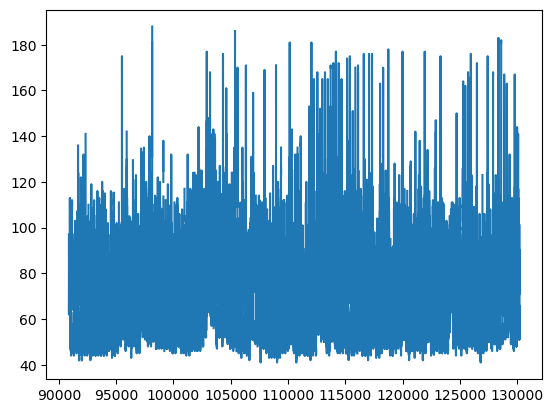

In [ ]:
sample_data['heartrate'].plot();

In [ ]:

filled_data = sample_data.fillna(column_name='heartrate', with_value=0.0)
print(f" Filled data has {filled_data['heartrate'].count()} entries and the unfilled data has {sample_data['heartrate'].count()} entries")


 Filled data has 130227 entries and the unfilled data has 34061 entries


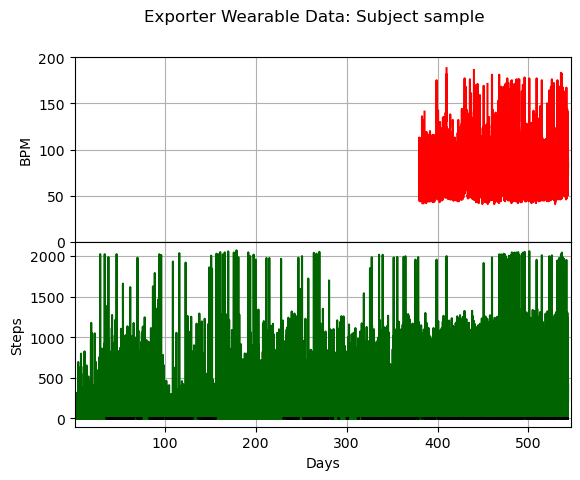

In [ ]:
sample_data.plot_hr_steps()

We can also make an actogram of the steps data to show the long term patterns in the behavior. 

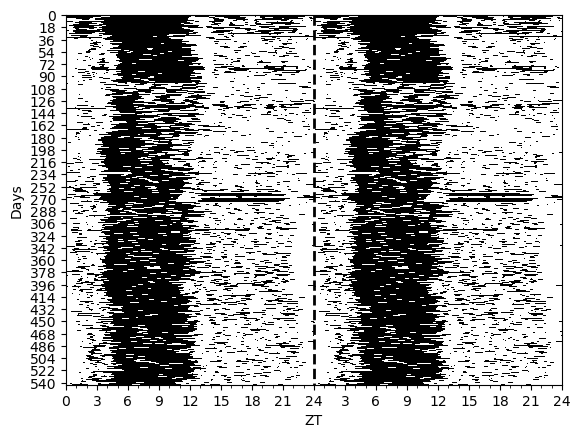

In [ ]:

Actogram(sample_data.time_total, sample_data.steps);

## Saving and Loading JSON

To save a `WearableData` object to json we can use

```{python}
sample_data.to_json('test_export.json')
```

and to load this back in we can do:

```{python}
wdata_loaded = WearableData.from_json('test_export.json')
```

In [ ]:
#| export

@patch 
def plot_light_activity(self: WearableData, 
                        show=True, 
                        vlines=None, 
                        *args, **kwargs):

        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True)
        fig.suptitle(
            f"{self.data_id} Subject {self.subject_id}")
        ax[0].plot(self.time_total / 24.0, np.log10(self.light_estimate+1.0), color='red')
        ax[1].plot(self.time_total / 24.0, self.activity, color='darkgreen')
        
        try:
            ax[1].plot(self.time_total / 24.0, self.wake *
                       np.median(self.steps), color='k')
        except:
            print(f"Error with wake plot with {self.subject_id}")

        if self.phase_measure_times is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]

        if vlines is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='cyan')
             for _x in vlines]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='cyan')
             for _x in vlines]

        ax[1].set_xlabel("Days")
        ax[0].set_ylabel("Lux (log 10)")
        ax[1].set_ylabel("Activity Counts")
        ax[0].grid()
        ax[1].grid()
        if show:
            plt.show()
        else:
            return ax


## Actiwatch Readers 

Expected format for this follows the guidelines on [predictdlmo](www.predictdlmo.com). Should be a CSV file with the columns

Date,Time,Activity,White Light,Sleep/Wake



In [ ]:
#| export

def read_actiwatch(filepath: str, # path to actiwatch csv file
                        MIN_LIGHT_THRESHOLD=5000, # used to trim off empty data at the beginning and end of the file, must reach this amount of light to be included. Turn this off can setting this to 0 or negative
                        round_data=True, # round the data to the nearest bin_minutes
                        bin_minutes=6, # bin the data to this resolution in minutes, only used if round_data is true
                        dt_format: str = None, # format of the date time string, if None, will be inferred
                        data_id: str = "Actiwatch", # name of the data source
                        subject_id: str = "unknown-subject", #subject id to be used
                        ) -> WearableData:
    
    df = pd.read_csv(filepath, names=['Date', 'Time', 'Activity', 'White Light', 'Sleep/Wake'], header=0) 
    df['datetime'] = df['Date']+" "+df['Time']
    if dt_format is None:
        df['datetime'] = pd.to_datetime(df.datetime, infer_datetime_format=True)
    else:
        df['datetime'] = pd.to_datetime(df.datetime, format=dt_format)

    df['UnixTime'] = (
        df['datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
    df.rename(columns={'White Light': 'light_estimate'}, inplace=True)
    df.rename(columns={'Sleep/Wake': 'wake'}, inplace=True)
    df.rename(columns={'Activity': 'activity'}, inplace=True)

    df['light_estimate'].fillna(0, inplace=True)
    df['LightSum'] = np.cumsum(df.light_estimate.values)
    df['LightSumReverse'] = np.sum(
        df.light_estimate.values) - np.cumsum(df.light_estimate.values) + 1.0

    df = df[(df.LightSum > MIN_LIGHT_THRESHOLD) & (
        df.LightSumReverse > MIN_LIGHT_THRESHOLD)]

    time_start = WearableData.utc_to_hrs(df.datetime.iloc[0])
    df2 = df[['UnixTime']].copy(deep=True)
    base_unix_time = df2['UnixTime'].iloc[0]
    df['time_total'] = time_start + \
        (df2.loc[:, ['UnixTime']]-base_unix_time)/3600.0
        
    df['timestamp'] = df['UnixTime']
    
    df = df[["datetime", "timestamp", "time_total", "activity", "light_estimate", "wake"]]
    if round_data:
        df.set_index('datetime', inplace=True)
        df = df.resample(str(int(bin_minutes))+'Min').agg({'time_total': 'min',
                                                            'activity': 'sum',
                                                            'light_estimate': 'median',
                                                            'wake': 'max'})
        df.reset_index(inplace=True)
    df['time_total'].interpolate(inplace=True)
    df.activity.fillna(0.0, inplace=True) 
    df.light_estimate.fillna(0.0, inplace=True)
    return WearableData(
        _dataframe = df,
        data_id=data_id,
        subject_id=subject_id
    )


In [ ]:
lib_path = circadian.__path__[0]
sample_actiwatch = read_actiwatch(filepath = lib_path + "/sample_data/sample_actiwatch.csv")

sample_actiwatch._dataframe.head()

,datetime,time_total,activity,light_estimate,wake
0,2019-02-20 01:00:00,1.0,2720.0,345.435,1.0
1,2019-02-20 01:06:00,1.1,2162.0,924.555,1.0
2,2019-02-20 01:12:00,1.2,2341.0,1057.800,1.0
3,2019-02-20 01:18:00,1.3,2208.0,717.810,1.0
4,2019-02-20 01:24:00,1.4,2639.0,3.820,1.0


We can make some plots of the actiwatch data to help visualize it

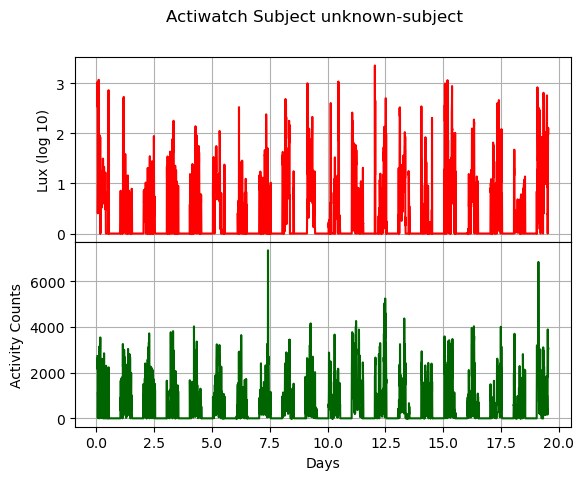

In [ ]:
sample_actiwatch.plot_light_activity()

Can also make use of the pandas plotting functions under the hood, by accessing the underlying dataframe. 

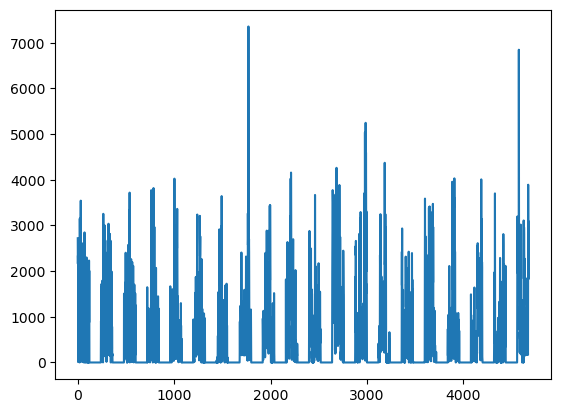

In [ ]:
sample_actiwatch._dataframe.activity.plot();

Here is an example of creating an actogram from the sample actiwatch data and adding in DLMO predictions from the Hannay single population model. 

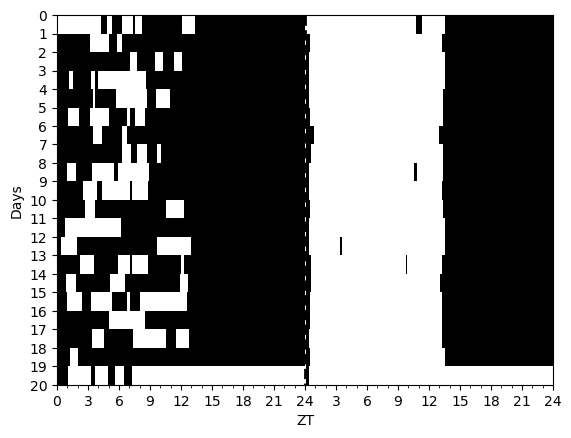

In [ ]:

acto = Actogram(sample_actiwatch.time_total, 
                sample_actiwatch.light_estimate, 
                second_zeit=sample_actiwatch.activity);


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()